In [1]:
from metric_learn.lmnn import LMNN
from metric_learn.covariance import Covariance
from metric_learn.mlkr import MLKR
from scipy.io import loadmat
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(9999999)

In [2]:
# Load all of the saved files
train_feat = np.loadtxt('train_feat.gzip', dtype = 'float')
gallery_feat = np.loadtxt('gallery_feat.gzip', dtype = 'float')
query_feat = np.loadtxt('query_feat.gzip', dtype = 'float')
val_feat = np.loadtxt('val_feat.gzip', dtype = 'float')
train_noval_feat = np.loadtxt('train_noval_feat.gzip', dtype = 'float')
train_labels = np.loadtxt('train_labels.gzip', dtype = 'uint16')
gallery_labels = np.loadtxt('gallery_labels.gzip', dtype = 'uint16')
query_labels = np.loadtxt('query_labels.gzip', dtype = 'uint16')
val_labels = np.loadtxt('val_labels.gzip', dtype = 'uint16')
train_noval_labels = np.loadtxt('train_noval_labels.gzip', dtype = 'uint16')
#train_filelist = np.loadtxt('train_filelist.gzip', dtype = 'uint16')
#gallery_filelist = np.loadtxt('gallery_filelist.gzip', dtype = 'uint16')
#query_filelist = np.loadtxt('query_filelist.gzip', dtype = 'uint16')
#val_filelist = np.loadtxt('val_filelist.gzip', dtype = 'uint16')
#train_noval_filelist = np.loadtxt('train_noval_filelist.gzip', dtype = 'uint16')
train_camId = np.loadtxt('train_camId.gzip', dtype = 'uint16') # uint8
gallery_camId = np.loadtxt('gallery_camId.gzip', dtype = 'uint16')
query_camId = np.loadtxt('query_camId.gzip', dtype = 'uint16')
val_camId = np.loadtxt('val_camId.gzip', dtype = 'uint16')
train_noval_camId = np.loadtxt('train_noval_camId.gzip', dtype = 'uint16')

In [3]:
#Create gallery and query set for validation
val_label_cam_pair = np.append(val_labels.reshape((1,val_labels.shape[0])),val_camId.reshape((1,val_camId.shape[0])),axis=0)
val_pair_unique, val_pair_unique_indxs = np.unique(val_label_cam_pair, axis=1, return_index=True)
print(val_pair_unique, val_pair_unique_indxs, val_pair_unique.shape)

val_query_feat = val_feat[val_pair_unique_indxs,:]
val_query_labels = val_labels[val_pair_unique_indxs]
val_query_camId = val_camId[val_pair_unique_indxs]

val_gallery_feat = np.delete(val_feat, val_pair_unique_indxs, axis = 0)
val_gallery_labels = np.delete(val_labels, val_pair_unique_indxs)
val_gallery_camId = np.delete(val_camId, val_pair_unique_indxs)

idxs_delete = []
for i in range(val_query_labels.shape[0]):
    g_camId = val_gallery_camId[val_gallery_labels==val_query_labels[i]]
    if (val_query_camId[i]==1 and (2 not in g_camId)) or (val_query_camId[i]==2 and (1 not in g_camId)):
        val_gallery_feat = np.append(val_gallery_feat, val_query_feat[[i],:],axis=0)
        val_gallery_labels = np.append(val_gallery_labels, val_query_labels[i])
        val_gallery_camId = np.append(val_gallery_camId, val_query_camId[i])
        idxs_delete.append(i)

val_query_feat = np.delete(val_query_feat, idxs_delete, axis = 0)
val_query_labels = np.delete(val_query_labels, idxs_delete)
val_query_camId = np.delete(val_query_camId, idxs_delete)

print(val_feat.shape, val_labels.shape)
print(val_query_feat.shape, val_query_labels.shape, val_query_camId.shape, val_gallery_feat.shape, val_gallery_labels.shape, val_gallery_camId.shape)


[[   2    2    8 ... 1466 1467 1467]
 [   1    2    1 ...    2    1    2]] [   0    5   10 ... 5749 5754 5759] (2, 1199)
(5764, 2048) (5764,)
(1190, 2048) (1190,) (1190,) (4574, 2048) (4574,) (4574,)


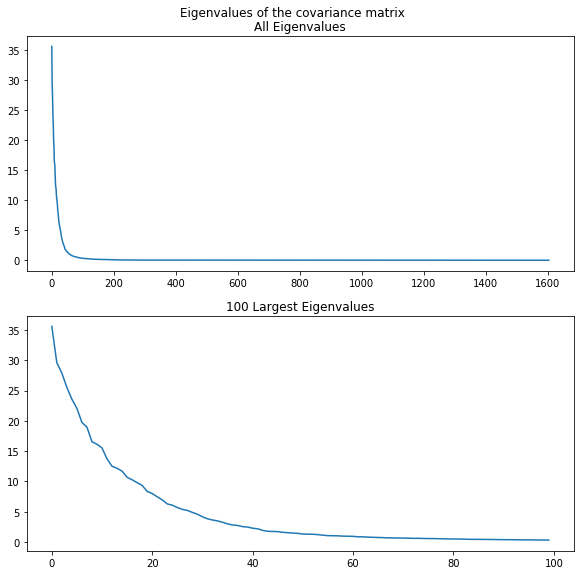

Percentage of total data variance captured: 0.9962195660564382


In [4]:
#DO PCA
pca_train_noval =PCA()
pca_train_noval.fit(train_noval_feat)
pca_train_noval_eigvals = pca_train_noval.explained_variance_

x = np.arange(0, pca_train_noval_eigvals.shape[0])
fig, axs = plt.subplots(2, 1, constrained_layout = True, figsize = (8, 8))
axs[0].plot(x, pca_train_noval_eigvals, '-')
axs[0].set_title('All Eigenvalues')

fig.suptitle('Eigenvalues of the covariance matrix')
axs[1].plot(x[:100], pca_train_noval_eigvals[:100], '-')
axs[1].set_title('100 Largest Eigenvalues')
plt.show()

print("Percentage of total data variance captured:", 
      (np.sum(pca_train_noval_eigvals[:500]))/(np.sum(pca_train_noval_eigvals[:500])+np.sum(pca_train_noval_eigvals[500:])))

In [5]:
pca = PCA(n_components=500)
#train_noval_feat_reduced = pca.fit_transform(train_noval_feat)
train_feat_reduced = pca.fit_transform(train_feat)
query_feat_reduced = pca.transform(query_feat)
gallery_feat_reduced = pca.transform(gallery_feat)

In [7]:
# Create a dict storing the differently transformed features
feat_dict_val = {}
#feat_dict_val["basecase"] = (val_query_feat, val_gallery_feat)

feat_dict = {}
feat_dict["basecase"] = (query_feat, gallery_feat)

In [8]:
Cov_Model = Covariance().fit(train_feat, train_labels)
query_feat_Cov = Cov_Model.transform(query_feat)
gallery_feat_Cov = Cov_Model.transform(gallery_feat)

feat_dict["Covariance"]=(query_feat_Cov, gallery_feat_Cov)

In [9]:
Cov_Model_red = Covariance().fit(train_feat_reduced, train_labels)
query_feat_Cov_red = Cov_Model_red.transform(query_feat_reduced)
gallery_feat_Cov_red = Cov_Model_red.transform(gallery_feat_reduced)

feat_dict["PCA Covariance"]=(query_feat_Cov_red, gallery_feat_Cov_red)

In [10]:
LargeMarg_Model = LMNN(verbose=True).fit(train_feat,train_labels)
query_feat_LMNN = LargeMarg_Model.transform(query_feat)
gallery_feat_LMNN = LargeMarg_Model.transform(gallery_feat)

feat_dict["LMNN"]=(query_feat_LMNN, gallery_feat_LMNN)

#val_query_feat_M = M.transform(val_query_feat)
#val_gallery_feat_M = M.transform(val_gallery_feat)

#feat_dict_val["LMNN"]=(val_query_feat_M,val_gallery_feat_M)

/Users/paulstreli/anaconda3/lib/python3.7/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


2 765604.840951463 -2816.7135545150377 28 1.0099999999999999e-07
3 762768.9081833565 -2835.9327681064606 27 1.0201e-07
4 759915.330559735 -2853.5776236215606 27 1.030301e-07
5 757042.9118664921 -2872.4186932428274 26 1.0406040099999999e-07
6 754152.8838508255 -2890.0280156666413 25 1.0510100500999999e-07
7 751245.2307615664 -2907.6530892590526 24 1.0615201506009999e-07
8 748319.10616948 -2926.1245920864167 24 1.0721353521070098e-07
9 745375.0063233762 -2944.0998461038107 22 1.08285670562808e-07
10 742414.2419775826 -2960.7643457936356 21 1.0936852726843608e-07
11 739435.3387439473 -2978.9032336352393 21 1.1046221254112044e-07
12 736437.7864819139 -2997.5522620334523 19 1.1156683466653164e-07
13 733422.8023871669 -3014.984094746993 19 1.1268250301319696e-07
14 730388.6561803279 -3034.14620683901 19 1.1380932804332893e-07
15 727335.3770936322 -3053.2790866956348 19 1.1494742132376222e-07
16 724262.999090775 -3072.3780028572073 19 1.1609689553699984e-07
17 721171.7668415105 -3091.23224926

128 336019.60411245143 -2195.8330839408445 0 3.538461465303104e-07
129 333908.6814979336 -2110.9226145178545 0 3.573846079956135e-07
130 331885.66652041767 -2023.014977515908 0 3.6095845407556966e-07
131 329953.6294952233 -1932.0370251943823 0 3.645680386163254e-07
132 328115.71548472636 -1837.9140104969265 0 3.6821371900248867e-07
133 326375.14593111014 -1740.5695536162239 0 3.7189585619251353e-07
134 324735.22032324364 -1639.9256078664912 0 3.7561481475443865e-07
135 323199.3178983741 -1535.902424869535 0 3.7937096290198303e-07
136 321770.89937935583 -1428.4185190182761 0 3.8316467253100284e-07
137 320453.5087481455 -1317.39063121035 0 3.8699631925631286e-07
138 319250.77505628497 -1202.7336918605142 0 3.9086628244887597e-07
139 318166.4142731662 -1084.3607831187546 0 3.947749452733647e-07
140 317204.2311728165 -962.1831003497355 0 3.987226947260984e-07
141 316368.12126000365 -836.1099128128262 0 4.027099216733594e-07
142 315662.07273647375 -706.0485235298984 0 4.0673702089009297e-07

In [11]:
LargeMarg_Model_red = LMNN(verbose=True).fit(train_feat_reduced,train_labels)
query_feat_LMNN_red = LargeMarg_Model_red.transform(query_feat_reduced)
gallery_feat_LMNN_red = LargeMarg_Model_red.transform(gallery_feat_reduced)

feat_dict["PCA LMNN"]=(query_feat_LMNN_red, gallery_feat_LMNN_red)

/Users/paulstreli/anaconda3/lib/python3.7/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


2 699998.0252632935 -2792.716883032699 28 1.0099999999999999e-07
3 697186.21127761 -2811.8139856834896 28 1.0201e-07
4 694355.5908072696 -2830.62047034048 27 1.030301e-07
5 691507.1084430557 -2848.482364213909 27 1.0406040099999999e-07
6 688640.1988024368 -2866.909640618833 25 1.0510100500999999e-07
7 685756.6951635024 -2883.5036389344605 24 1.0615201506009999e-07
8 682855.1687544668 -2901.5264090355486 24 1.0721353521070098e-07
9 679934.8846191578 -2920.284135309048 23 1.08285670562808e-07
10 676997.545573817 -2937.3390453407774 22 1.0936852726843608e-07
11 674041.9277252572 -2955.6178485597484 22 1.1046221254112044e-07
12 671068.2703534646 -2973.657371792593 20 1.1156683466653164e-07
13 668077.0527478756 -2991.217605589074 19 1.1268250301319696e-07
14 665068.0312165193 -3009.0215313562658 19 1.1380932804332893e-07
15 662040.0048812247 -3028.0263352945913 19 1.1494742132376222e-07
16 658993.0065107241 -3046.9983705006307 19 1.1609689553699984e-07
17 655927.0736800486 -3065.93283067550

128 273240.137723109 -2196.979345712345 0 3.538461465303104e-07
129 271126.8992551456 -2113.2384679634124 0 3.573846079956135e-07
130 269100.36385819956 -2026.535396946012 0 3.6095845407556966e-07
131 267163.56605564046 -1936.7978025591 0 3.645680386163254e-07
132 265319.6142826743 -1843.9517729661893 0 3.6821371900248867e-07
133 263571.6925011498 -1747.921781524492 0 3.7189585619251353e-07
134 261923.06184811622 -1648.6306530335569 0 3.7561481475443865e-07
135 260377.06231881923 -1545.999529296998 0 3.7937096290198303e-07
136 258937.11448484383 -1439.9478339753987 0 3.8316467253100284e-07
137 257606.72124812542 -1330.3932367184025 0 3.8699631925631286e-07
138 256389.46963155566 -1217.2516165697598 0 3.9086628244887597e-07
139 255289.0326069416 -1100.4370246140752 0 3.947749452733647e-07
140 254309.1709610761 -979.8616458654869 0 3.987226947260984e-07
141 253453.73520070175 -855.4357603743556 0 4.027099216733594e-07
142 252726.66749716195 -727.0677035397966 0 4.0673702089009297e-07
143

In [12]:
MLKR_Model = MLKR(verbose=True).fit(train_feat,train_labels)
query_feat_MLKR = MLKR_Model.transform(query_feat)
gallery_feat_MLKR = MLKR_Model.transform(gallery_feat)

feat_dict["MLKR"]=(query_feat_MLKR, gallery_feat_MLKR)

[MLKR]
[MLKR]  Iteration      Objective Value    Time(s)
[MLKR] ------------------------------------------
[MLKR]          0         2.116000e+03      86.40
[MLKR] Training took    90.17s.


In [13]:
MLKR_Model_red = MLKR(verbose=True).fit(train_feat_reduced,train_labels)
query_feat_MLKR_red = MLKR_Model_red.transform(query_feat_reduced)
gallery_feat_MLKR_red = MLKR_Model_red.transform(gallery_feat_reduced)

feat_dict["PCA MLKR"]=(query_feat_MLKR_red, gallery_feat_MLKR_red)

[MLKR]
[MLKR]  Iteration      Objective Value    Time(s)
[MLKR] ------------------------------------------
[MLKR]          0         2.116000e+03      29.93
[MLKR] Training took    30.22s.


In [ ]:
#M_reduced = LMNN(verbose=True).fit(train_noval_feat_reduced,train_noval_labels)

#val_query_feat_reduced = pca.transform(val_query_feat)
#val_gallery_feat_reduced = pca.transform(val_gallery_feat)
#print(val_query_feat_reduced.shape, val_gallery_feat_reduced.shape)

#val_query_feat_M_reduced = M_reduced.transform(val_query_feat_reduced)
#val_gallery_feat_M_reduced = M_reduced.transform(val_gallery_feat_reduced)

#feat_dict_val["LMNN reduced"]=(val_query_feat_M_reduced,val_gallery_feat_M_reduced)

In [14]:
# Function that takes as input an index that refers to a query image
# and returns the val_gallery without the unnecessary pictures in it
# Remove the pictures from the gallery that have the same label and are taken by the same camera as out VAL_QUERY[index]
# picture in the query array
def get_removed_val_gallery (index, t_gallery_feat):
    selected_indices = np.logical_not(np.logical_and(val_gallery_camId == val_query_camId[index], val_gallery_labels == val_query_labels[index]))
    return t_gallery_feat[selected_indices, :], val_gallery_labels[selected_indices], val_gallery_camId[selected_indices]

In [15]:
for key, (t_query_feat, t_gallery_feat) in feat_dict_val.items():
    # k nearest neighbours implementation
    k = 10
    top_k_accuracies_rank = np.zeros((val_query_labels.shape[0],k))
    top_k_accuracies_classical = np.zeros((val_query_labels.shape[0],k))
    top_k_accuracies_recall = np.zeros((val_query_labels.shape[0],k))

    for i in range (0, val_query_labels.shape[0], 1):
        gallery_feat_removed, gallery_labels_removed, gallery_camId_removed = get_removed_val_gallery (i, t_gallery_feat)
        nbrs = NearestNeighbors(n_neighbors=k).fit(gallery_feat_removed)
        distances, indices = nbrs.kneighbors(t_query_feat[i:i+1, :])
        print(gallery_labels_removed[indices], val_query_labels[i])
        print("camIds:", gallery_camId_removed[indices], val_query_camId[i])
        is_same_label = (val_query_labels[i] == gallery_labels_removed[indices])
    
        for j in range (0, k, 1):
            top_k_accuracies_rank[i,j] = np.sum(is_same_label[0, :(j+1)]) != 0
            top_k_accuracies_classical[i,j]=np.sum(is_same_label[0, :(j+1)])/(j+1)
            top_k_accuracies_recall[i,j] = np.sum(is_same_label[0, :(j+1)])/np.sum(gallery_labels_removed==val_query_labels[i])

    average_precisions = np.zeros((val_query_labels.shape))
    for j in range (0, val_query_labels.shape[0], 1):
        recall = top_k_accuracies_recall[j, :]
        precision = top_k_accuracies_classical[j, :]
        index = (recall).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector recall)
        recall = recall[index]
        precision = precision[index]
        recall_range = np.arange(0, 1.1, 0.1)
        precision_range = np.zeros((recall_range.shape))
        for i in range (0, recall_range.shape[0], 1):    
            if (precision[recall>=recall_range[i]].size != 0):
                precision_range[i] = np.max(precision[recall>=recall_range[i]])
            else:     
                precision_range[i] = 0
        average_precisions[j] = np.mean(precision_range)
    
    print ("Mean average precision:", average_precisions.mean())
    

In [16]:
# Function that takes as input an index that refers to a query image
# and returns the gallery without the unnecessary pictures in it
# Remove the pictures from the gallery that have the same label and are taken by the same camera as out QUERY[index]
# picture in the query array
def get_removed_gallery (index, t_gallery_feat):
    selected_indices = np.logical_not(np.logical_and(gallery_camId == query_camId[index], gallery_labels == query_labels[index]))
    return t_gallery_feat[selected_indices, :], gallery_labels[selected_indices], gallery_camId[selected_indices]

In [ ]:
for key, (t_query_feat, t_gallery_feat) in feat_dict.items():
    # k nearest neighbours implementation
    k = 10
    top_k_accuracies_rank = np.zeros((query_labels.shape[0],k))
    top_k_accuracies_classical = np.zeros((query_labels.shape[0],k))
    top_k_accuracies_recall = np.zeros((query_labels.shape[0],k))

    for i in range (0, query_labels.shape[0], 1):
        gallery_feat_removed, gallery_labels_removed, gallery_camId_removed = get_removed_gallery (i, t_gallery_feat)
        nbrs = NearestNeighbors(n_neighbors=k).fit(gallery_feat_removed)
        distances, indices = nbrs.kneighbors(t_query_feat[i:i+1, :])
        print(gallery_labels_removed[indices], query_labels[i])
        print("camIds:", gallery_camId_removed[indices], query_camId[i])
        is_same_label = (query_labels[i] == gallery_labels_removed[indices])
    
        for j in range (0, k, 1):
            top_k_accuracies_rank[i,j] = np.sum(is_same_label[0, :(j+1)]) != 0
            top_k_accuracies_classical[i,j]=np.sum(is_same_label[0, :(j+1)])/(j+1)
            top_k_accuracies_recall[i,j] = np.sum(is_same_label[0, :(j+1)])/np.sum(gallery_labels_removed==query_labels[i])

    average_precisions = np.zeros((query_labels.shape))
    for j in range (0, query_labels.shape[0], 1):
        recall = top_k_accuracies_recall[j, :]
        precision = top_k_accuracies_classical[j, :]
        index = (recall).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector recall)
        recall = recall[index]
        precision = precision[index]
        recall_range = np.arange(0, 1.1, 0.1)
        precision_range = np.zeros((recall_range.shape))
        for i in range (0, recall_range.shape[0], 1):    
            if (precision[recall>=recall_range[i]].size != 0):
                precision_range[i] = np.max(precision[recall>=recall_range[i]])
            else:     
                precision_range[i] = 0
        average_precisions[j] = np.mean(precision_range)
    
    print (key, "Mean average precision:", average_precisions.mean())

[[1368  739 1426   51 1368   14   14 1450   51 1368]] 3
camIds: [[1 1 2 2 1 1 1 1 1 1]] 1
[[ 517  235  235 1426  725   86   51 1426  172    3]] 3
camIds: [[1 1 1 2 1 1 1 2 1 1]] 2
[[  6   6   6   6 678  77  77 678 678 648]] 6
camIds: [[2 2 2 2 2 1 1 2 1 1]] 1
[[  6   6   6   6 678 678 678 678 678  72]] 6
camIds: [[1 1 1 1 1 2 1 2 2 1]] 2
[[ 22   7 382  22   7 303   7 854   7 441]] 7
camIds: [[1 2 1 1 2 1 2 2 2 1]] 1
[[319 319   7 319   7   7   7 319  22  22]] 7
camIds: [[2 2 1 2 1 1 1 2 1 1]] 2
[[390 738  11 738  11  55  11 625 211  42]] 11
camIds: [[2 1 2 1 2 1 2 1 2 2]] 1
[[738  55 721  11 721 721 401 721 738 763]] 11
camIds: [[2 1 2 1 2 2 2 1 2 2]] 2
[[ 14  14   3  51  14  51  51 182 650  51]] 14
camIds: [[2 2 1 1 2 2 1 1 1 1]] 1
[[ 14  14  14  14 739 291  51 182 182 739]] 14
camIds: [[1 1 1 1 1 1 1 1 1 1]] 2
[[ 17  17  17  17  32 715  32  32  68  68]] 17
camIds: [[2 2 2 2 1 2 1 1 1 1]] 1
[[ 17  17  17  17 715  32 715  32 115 715]] 17
camIds: [[1 1 1 1 2 1 1 2 1 2]] 2
[[ 17  17  17 

[[727   3   3 769 575 769 769 725 727   3]] 119
camIds: [[1 1 1 2 2 1 1 1 1 1]] 1
[[727 727 727 303 303 303 695 303 174 303]] 119
camIds: [[2 2 2 2 2 2 2 1 2 1]] 2
[[1389    3  979  979  404  404 1098  404    3 1098]] 120
camIds: [[2 2 1 1 2 2 2 2 2 2]] 1
[[267 646 646 509 646 120 646 120 267 171]] 120
camIds: [[1 2 2 1 2 1 2 1 1 2]] 2
[[121 121 578 923 578 558 923 558 578 923]] 121
camIds: [[2 2 2 2 2 1 2 1 2 2]] 1
[[ 121  121  121 1187 1187  558 1187  599  558  653]] 121
camIds: [[1 1 1 1 1 1 2 2 1 2]] 2
[[123 123 123 450 123 134 220 134 149 988]] 123
camIds: [[2 2 2 1 2 1 2 1 1 1]] 1
[[123 859 381 149 699 859 699 123 400 400]] 123
camIds: [[1 1 2 1 1 1 1 1 1 1]] 2
[[127 127 127 127 494 653 437 732 349  86]] 127
camIds: [[2 2 2 2 1 2 1 1 1 2]] 1
[[127 127 127 127 732 732 732 732 143 143]] 127
camIds: [[1 1 1 1 1 2 2 2 1 1]] 2
[[128 823 163 552 128 504 552 163 128 823]] 128
camIds: [[2 1 2 1 2 1 1 2 2 1]] 1
[[128 128 129 241 128 128 738 241 241 129]] 128
camIds: [[1 1 2 1 1 1 2 1 1 2]